In this assignment, we will use a library for probabilistic programming and inference called PyMC3.

In [9]:
import numpy as np
import pandas as pd
import numpy.random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
import pymc3 as pm
from time import time

Suppose Alice and Bob are trading on the market. Both of them are selling the Thing and want to get as high profit as possible. Every hour they check out with each other's prices and adjust their prices to compete on the market. Although they have different strategies for price setting.

Alice: takes Bob's price during the previous hour, multiply by 0.6, add $90, add Gaussian noise from 𝑁(0,202).

Bob: takes Alice's price during the current hour, multiply by 1.2 and subtract $20, add Gaussian noise from 𝑁(0,102).

The problem is to find the joint distribution of Alice and Bob's prices after many hours of such an experiment.

We simulate their strategy to get the corresponding data:

In [10]:
def run_simulation(alice_start_price=300.0, bob_start_price=300.0, seed=42, num_hours=10000, burnin=1000):
    """Simulates an evolution of prices set by Bob and Alice.
    
    The function should simulate Alice and Bob behavior for `burnin' hours, then ignore the obtained
    simulation results, and then simulate it for `num_hours' more.
    The initial burnin (also sometimes called warmup) is done to make sure that the distribution stabilized.
    
    Please don't change the signature of the function.
    
    Returns:
        two lists, with Alice and with Bob prices. Both lists should be of length num_hours.
    """
    np.random.seed(seed)

    alice_prices = [alice_start_price]
    bob_prices = [bob_start_price]
    
    for _ in range(num_hours):
        
        a = bob_prices[-1] * 0.6 + 90 + np.random.normal(0,20)
        alice_prices.append(a)
      
        a = alice_prices[-1] * 1.2 - 20 + np.random.normal(0,10)
        bob_prices.append(a)
            
    return alice_prices[burnin:], bob_prices[burnin:]

We can find the average prices for both of them to see who has higher prices.

In [11]:
average_alice_price = np.mean(run_simulation()[0])
average_bob_price = np.mean(run_simulation()[1])
average_alice_price, average_bob_price

(278.62821295463834, 314.37642287694996)

Let's look at the 2-d histogram of prices, computed using kernel density estimation.

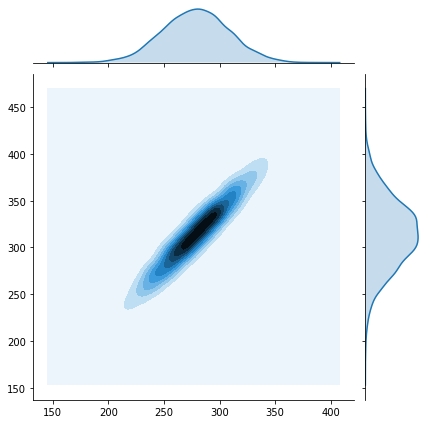

In [12]:
data = np.array(run_simulation())
sns.jointplot(data[0], data[1], stat_func=None, kind='kde')

Clearly, the prices of Bob and Alce are highly correlated. We know this from the way the data was created. What is the Pearson correlation coefficient of Alice and Bob prices?

In [16]:
np.corrcoef(run_simulation()[0],run_simulation()[1])[0,1]

0.9636340025161768

which is confirmed.

We observe an interesting effect here: seems like the bivariate distribution of Alice and Bob prices converges to a correlated bivariate Gaussian distribution.

Let's check, whether the results change if we use different random seed and starting points. We expect it not to change.


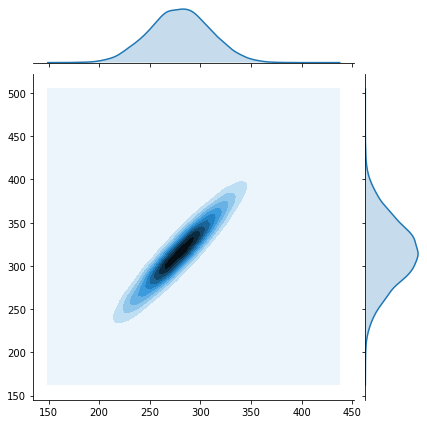

In [17]:
data = np.array(run_simulation(30, 10, 1, 10000, 1000))
sns.jointplot(data[0], data[1], stat_func=None, kind='kde')

### Logistic Regression and Inference using PyMc3

Logistic regression is a powerful model that allows you to analyze how a set of features affects some binary target label. Posterior distribution over the weights gives us an estimation of the influence of each particular feature on the probability of the target being equal to one. But most importantly, the posterior distribution gives us the interval estimates for each weight of the model. This is very useful for data analysis when we want to not only provide a good model but also estimate the uncertainty of your conclusions.

In the following, we will use PyMC3 library to perform approximate Bayesian inference for logistic regression. 

The problem here is to model how the probability that a person has salary $\geq$ \\$50K is affected by his/her age, education, sex and other features.

Let $y_i = 1$ if $i$th person's salary is $\geq$ \\$50K and $y_i = 0$ otherwise. Let $x_{ij}$ be $j$-th feature of $i$-th person.

Logistic regression models this probabilty in the following way:
$$p(y_i = 1 \mid \beta) = \sigma (\beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_k x_{ik} ),$$
where $\sigma(t) = \frac1{1 + e^{-t}}$.

### Odds

Let's try to answer the following question: does the gender of a person affects his or her salary? To do it we will use the concept of *odds*.

If we have a binary random variable $y$ (which may indicate whether a person makes \\$50K) and if the probabilty of the positive outcome $p(y = 1)$ is for example 0.8, we will say that the *odds* are 4 to 1 (or just 4 for short), because succeding is 4 time more likely than failing $\frac{p(y = 1)}{p(y = 0)} = \frac{0.8}{0.2} = 4$.

Now, let's return to the effect of gender on the salary. Let's compute the **ratio** between the odds of a male having salary $\geq $ \\$50K and the odds of a female (with the same level of education, experience and everything else) having salary $\geq$ \\$50K. The first feature of each person in the dataset is gender. Specifically, $x_{i1} = 0$ if the person is female and $x_{i1} = 1$ otherwise. Consider two people $i$ and $j$ having all but one features the same with the only difference in $x_{i1} \neq x_{j1}$.

If the logistic regression model above estimates the probabilities exactly, the odds for a male will be (check it!):
$$
\frac{p(y_i = 1 \mid x_{i1}=1, x_{i2}, \ldots, x_{ik})}{p(y_i = 0 \mid x_{i1}=1, x_{i2}, \ldots, x_{ik})} = \frac{\sigma(\beta_1 + \beta_2 x_{i2} + \ldots)}{1 - \sigma(\beta_1 + \beta_2 x_{i2} + \ldots)} = \exp(\beta_1 + \beta_2 x_{i2} + \ldots)
$$

Now the ratio of the male and female odds will be:
$$
\frac{\exp(\beta_1 \cdot 1 + \beta_2 x_{i2} + \ldots)}{\exp(\beta_1 \cdot 0 + \beta_2 x_{i2} + \ldots)} = \exp(\beta_1)
$$

So given the correct logistic regression model, we can estimate odds ratio for some feature (gender in this example) by just looking at the corresponding coefficient. But of course, even if all the logistic regression assumptions are met we cannot estimate the coefficient exactly from real-world data, it's just too noisy. So it would be really nice to build an interval estimate, which would tell us something along the lines "with probability 0.95 the odds ratio is greater than 0.8 and less than 1.2, so we cannot conclude that there is any gender discrimination in the salaries" (or vice versa, that "with probability 0.95 the odds ratio is greater than 1.5 and less than 1.9 and the discrimination takes place because a male has at least 1.5 higher probability to get >$50k than a female with the same level of education, age, etc."). In Bayesian statistics, this interval estimate is called *credible interval*.

Unfortunately, it's impossible to compute this credible interval analytically. So let's use MCMC to do that!

#### Credible interval
A credible interval for the value of $\exp(\beta_1)$ is an interval $[a, b]$ such that $p(a \leq \exp(\beta_1) \leq b \mid X_{\text{train}}, y_{\text{train}})$ is $0.95$ (or some other predefined value). To compute the interval, we need access to the posterior distribution $p(\exp(\beta_1) \mid X_{\text{train}}, y_{\text{train}})$.

Lets for simplicity focus on the posterior on the parameters $p(\beta_1 \mid X_{\text{train}}, y_{\text{train}})$ since if we compute it, we can always find $[a, b]$ such that $p(\log a \leq \beta_1 \leq \log b \mid X_{\text{train}}, y_{\text{train}}) = p(a \leq \exp(\beta_1) \leq b \mid X_{\text{train}}, y_{\text{train}}) = 0.95$


We query the data:

In [10]:
data = pd.read_csv("adult_us_postprocessed.csv")
data.head()

,sex,age,educ,hours,income_more_50K
0,Male,39,13,40,0
1,Male,50,13,13,0
2,Male,38,9,40,0
3,Male,53,7,40,0
4,Female,28,13,40,0


Each row of the dataset is a person with his (her) features. The last column is the target variable $y$. One indicates that this person's annual salary is more than $50K.

First of all let's set up a Bayesian logistic regression model (i.e. define priors on the parameters $\alpha$ and $\beta$ of the model) that predicts the value of "income_more_50K" based on person's age and education:

$$
p(y = 1 \mid \alpha, \beta_1, \beta_2) = \sigma(\alpha + \beta_1 x_1 + \beta_2 x_2) \\ 
\alpha \sim N(0, 100^2) \\
\beta_1 \sim N(0, 100^2) \\
\beta_2 \sim N(0, 100^2), \\
$$

where $x_1$ is a person's age, $x_2$ is his/her level of education, y indicates his/her level of income, $\alpha$, $\beta_1$ and $\beta_2$ are paramters of the model. Now we built a probabilistic model using PyMc3 as follows:

In [4]:
with pm.Model() as manual_logistic_model:
    # Declare pymc random variables for logistic regression coefficients with uninformative 
    # prior distributions N(0, 100^2) on each weight using pm.Normal. 
    
    ## Distribution of priors
    
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta_1 = pm.Normal('beta_1', mu=0, sd=100)
    beta_2 = pm.Normal('beta_2', mu=0, sd=100)
    
    
    # Transform these random variables into vector of probabilities p(y_i=1) using logistic regression model specified 
    # above. PyMC random variables are theano shared variables and support simple mathematical operations.
    # For example:
    # z = pm.Normal('x', 0, 1) * np.array([1, 2, 3]) + pm.Normal('y', 0, 1) * np.array([4, 5, 6])`
    # is a correct PyMC expression.
    # We use pm.invlogit for the sigmoid function.
    
    p = pm.invlogit(alpha + beta_1 * data['age'] +\
                    beta_2 * data['educ'])
    
    # Declare PyMC Bernoulli random vector with probability of success equal to the corresponding value
    # given by the sigmoid function.
    # Supply target vector using "observed" argument in the constructor.

    
    y_obs= pm.Bernoulli("y", p=p, observed=data['income_more_50K'])

    
    # Use pm.find_MAP() to find the maximum a-posteriori estimate for the vector of logistic regression weights.
    map_estimate = pm.find_MAP()
    print(map_estimate)



logp = -18,844, ||grad|| = 57,293: 100%|██████████| 30/30 [00:00<00:00, 171.82it/s]   


{'alpha': array(-6.74811904), 'beta_1': array(0.04348316), 'beta_2': array(0.36210803)}


One can train the same model suing a more convenient interface of PyMc3, that is pm.glm.GLM.from_formula, as follows:

In [5]:
with pm.Model() as logistic_model:
   
    # Note that the target variable is binary (and hence follows Binomial distribution).
    
    pm.glm.GLM.from_formula('income_more_50K~age+educ', data, family=pm.glm.families.Binomial())
    

    map_estimate = pm.find_MAP()
    print(map_estimate)

logp = -15,131, ||grad|| = 0.024014: 100%|██████████| 32/32 [00:00<00:00, 253.72it/s]    

{'Intercept': array(-6.7480998), 'age': array(0.04348259), 'educ': array(0.36210894)}


## MCMC Inference

We use the following function for visualization. 

In [11]:
def plot_traces(traces, burnin=200):
    ''' 
    Convenience function:
    Plot traces with overlaid means and values
    '''
    
    ax = pm.traceplot(traces[burnin:], figsize=(12,len(traces.varnames)*1.5),
        lines=tuple([(k, {}, v['mean']) 
                     for k, v in pm.summary(traces[burnin:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[burnin:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

### Metropolis-Hastings
Let's use the Metropolis-Hastings algorithm for finding the samples from the posterior distribution.

Agian, there's a more conveinent interface for generalized linear models using pm.glm.GLM.from_formula that can be used for sampling.  

In [ ]:
data['age2'] = np.array(data['age'])**2

with pm.Model() as logistic_model:
    
    pm.glm.GLM.from_formula('income_more_50K~sex+age+age2+educ+hours', data, family=pm.glm.families.Binomial())
    
    trace = pm.sample(400, step=pm.Metropolis(), init='advi_map', random_seed=123, tune=1000)

Unfortunately, in my machine, python quits when I run this interface because there is a problem when the interface tries to parallel sampling multiple chains. So I use the regular method below:

In [12]:
data.loc[:, 'sex'] = (data['sex'] == 'Male').astype('int')

In [13]:

with pm.Model() as logistic_model:
    
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta_1 = pm.Normal('beta_1', mu=0, sd=100)
    beta_2 = pm.Normal('beta_2', mu=0, sd=100)
    beta_3 = pm.Normal('beta_3', mu=0, sd=100)
    beta_4 = pm.Normal('beta_4', mu=0, sd=100)
    beta_5 = pm.Normal('beta_5', mu=0, sd=100)

    p = pm.invlogit(alpha +\
                    beta_1 * data['sex'] +\
                    beta_2 * data['age'] +\
                    beta_3 * data['age']**2 +\
                    beta_4 * data['educ'] +\
                    beta_5 * data['hours'])
    
    
    y_obs= pm.Bernoulli("y", p=p, observed=data['income_more_50K'])
    
    
    trace = pm.sample(400, step=pm.Metropolis(), init='advi_map', random_seed=123, tune=1000)


Only 400 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_5]
>Metropolis: [beta_4]
>Metropolis: [beta_3]
>Metropolis: [beta_2]
>Metropolis: [beta_1]
>Metropolis: [alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 5600/5600 [00:50<00:00, 111.94draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


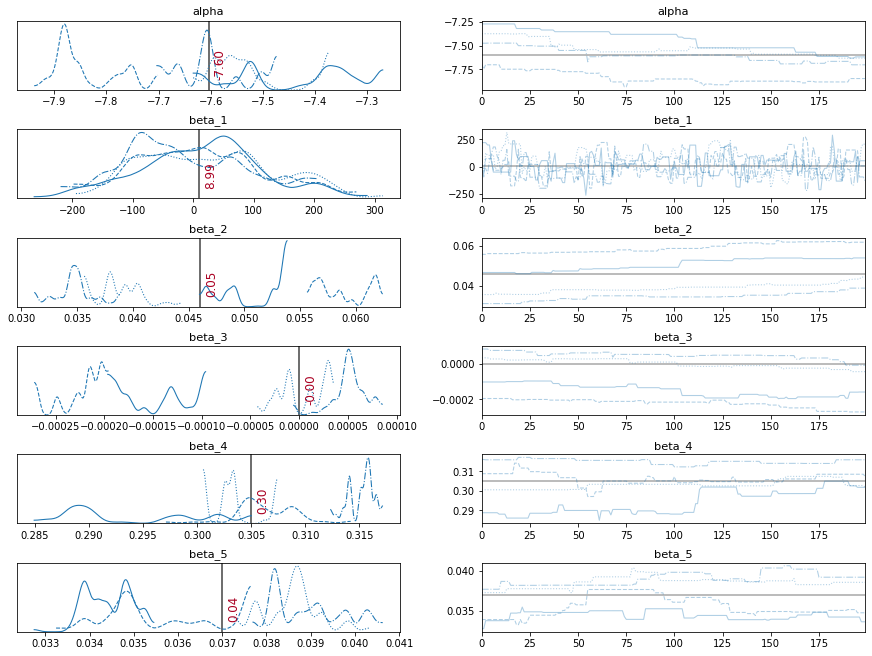

In [14]:
plot_traces(trace)

We can get better results using NUTS sampler as follows:

### NUTS sampler
This time, we use pm.sample without specifying a particular sampling method (pymc3 will choose it automatically).
The sampling algorithm that will be used in this case is NUTS, which is a form of Hamiltonian Monte Carlo, in which parameters are tuned automatically. This is an advanced method that usually converges faster and gives less correlated samples compared to vanilla Metropolis-Hastings.

In [15]:
with pm.Model() as logistic_model:
    
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta_1 = pm.Normal('beta_1', mu=0, sd=100)
    beta_2 = pm.Normal('beta_2', mu=0, sd=100)
    beta_3 = pm.Normal('beta_3', mu=0, sd=100)
    beta_4 = pm.Normal('beta_4', mu=0, sd=100)
    beta_5 = pm.Normal('beta_5', mu=0, sd=100)

    p = pm.invlogit(alpha +\
                    beta_1 * data['sex'] +\
                    beta_2 * data['age'] +\
                    beta_3 * data['age']**2 +\
                    beta_4 * data['educ'] +\
                    beta_5 * data['hours'])
    
    
    y_obs= pm.Bernoulli("y", p=p, observed=data['income_more_50K'])
    
    trace1 = pm.sample(500, init='adapt_diag', random_seed=123, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_5, beta_4, beta_3, beta_2, beta_1, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [27:21<00:00,  3.65draws/s]  


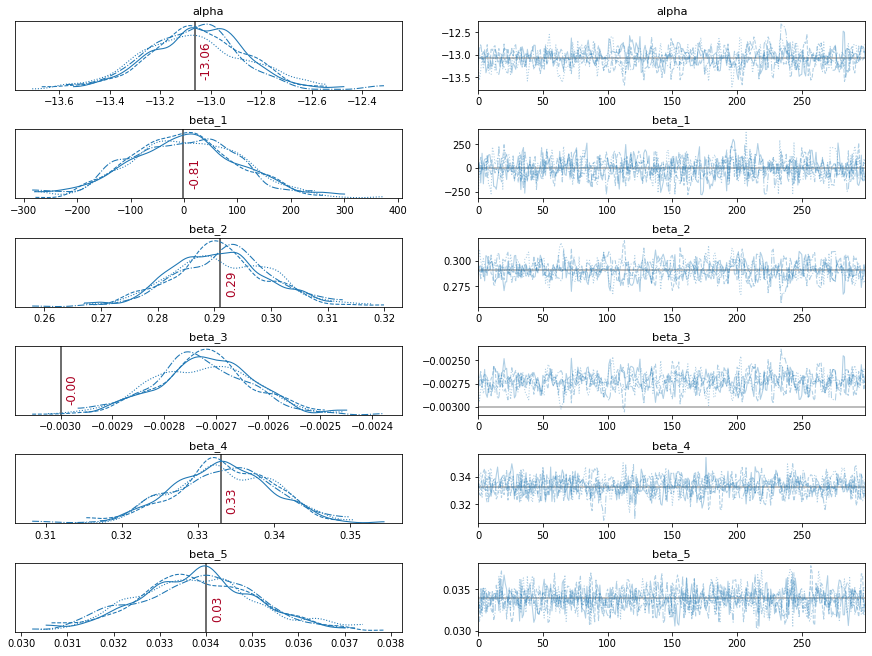

In [17]:
plot_traces(trace1)

### Estimating the odds ratio
Now, let's build the posterior distribution on the odds ratio given the dataset (approximated by MCMC).

/Users/Yas/DS/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


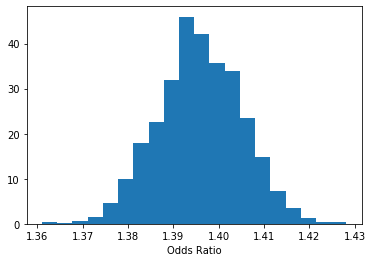

In [18]:
burnin = 100
b = trace1['beta_4'][burnin:] # MCMC samples from the distribution of beta_4
plt.hist(np.exp(b), bins=20, normed=True)
plt.xlabel("Odds Ratio")
plt.show()

Finally, we can find a credible interval  (recall that credible intervals are Bayesian and confidence intervals are frequentist) for this quantity. This may be the best part about Bayesian statistics: we get to interpret credibility intervals the way we've always wanted to interpret them. We are 95% confident that the odds ratio lies within our interval!

In [19]:
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
print("P(%.3f < Odds Ratio < %.3f) = 0.95" % (np.exp(lb), np.exp(ub)))

P(1.378 < Odds Ratio < 1.413) = 0.95


Therefore, according to our data, we are 95% sure that a female is *less* likely to get >$50K than a male with the same age, level of education, etc.
